# DLnet for inverse problem

An implementation of the deep unfolding IPM method, solution of an inverse problem with a neural network inspired from a diagonal landweber regularization under inequality constraint.

Author: Cecile Della Valle

Date: 20.06.2020

Last updated: 20.06.2020 

We start with importing all the relevant libraries.

In [1]:
%matplotlib inline
import os
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

Next, we load the training and test samples of our dataset.

In [2]:
training_batch_size = 100
test_batch_size = 10000

# Train dataset and dataloader declaration


# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=test_batch_size, shuffle=True)

We now define the ODEnet class that allows to initialise instances of ODEnet. Parameters are the dimensions of the weight matrices *weight_dimensions*, the number of classes *number_of_classes* and the number of layers *number_of_layers*. Note that this class implements the forward Euler discretisation of the ODEnet, i.e.

$ y^{[j + 1]} = y^{[j]} + \alpha^{[j]} \sigma( K^{[j]} y^{[j]} + \beta^{[j]} ) \, , $

for the point-wise activation function $ \sigma(x) = \tanh(x) $ and parameters $ K^{[j]} \in \mathbb{R}^{\text{weight_dimensions} \times \text{weight_dimensions}} $ , $ \beta^{[j]} \in \mathbb{R}^{\text{weight_dimensions}} $ , for $ j = 1, \ldots, \text{number_of_layers} $ , and $ \alpha \in \mathbb{R}^{\text{number_of_layers}} $. The initial value is specified via $ y^{[0]} = x $ where $ x $ denotes the input. The forward Euler discretisation is performed via the function call *ode_forward*, whereas *forward* evaluates the network and maps its output $ y^{[\text{number_of_layers}]} $ onto $ W y^{[\text{number_of_layers}]} $ for $ W \in \mathbb{R}^{\text{number_of_classes} \times \text{weight_dimensions}} $.

In [3]:
class DLnet(nn.Module):
    def __init__(self, weight_dimensions, number_of_classes, number_of_layers):
        super(ODEnet, self).__init__()
        self.affine_transformations = nn.ModuleList([nn.Linear(weight_dimensions, \
                                            weight_dimensions) for k in range(number_of_layers)])
        self.linear_output_transformation = nn.Linear(weight_dimensions, number_of_classes, \
                                                      bias=False)
        self.activation_function = nn.Tanh()        
        self.step_sizes = nn.Parameter(1/number_of_layers * torch.ones(number_of_layers))
        self.number_of_layers = number_of_layers
    
    def dl_forward(self, x):
        y = x
        for k in range(self.number_of_layers):
            y = y + self.step_sizes[k] * self.activation_function(self.affine_transformations[k](y))
        return y
    
    def forward(self, x):
        y = self.ode_forward(x)
        return self.linear_output_transformation(y)

Furthermore, we define a function that computes the classification accuracy of the outputs *outputs* of a network for given labels *labels*.

In [ ]:
def accuracy(outputs, labels):
    prediction = outputs.max(1, keepdim=True)[1].squeeze()
    prediction_comparison = torch.eq(prediction, labels)
    return 100 * (prediction_comparison.sum().numpy() / torch.numel(prediction_comparison))

Next, we initialise an instance *ode_net* of the class *ODEnet* for the parameters specified below.

In [4]:
number_of_pixels = 784
number_of_classes = 10
number_of_layers = 10
ode_net = ODEnet(number_of_pixels, number_of_classes, number_of_layers)

We train the ODEnet based on the MNIST training samples by minimising the cross entropy loss of the network output and the labels of the training data with stochastic gradient descent for the parameters specified in the code below.

In [5]:
criterion = nn.CrossEntropyLoss()
number_of_epochs = 150
step_size = 0.1
momentum_parameter = 0.7
optimiser = optim.SGD(ode_net.parameters(), lr=step_size, momentum=momentum_parameter)

running_loss = []
running_training_accuracy = []
running_training_accuracy.append(10)
running_test_accuracy = []
running_test_accuracy.append(10)

for k in range(number_of_epochs):
    
    # for data, target in train_loader:   
    for j, (images, labels) in enumerate(train_loader):
        
        optimiser.zero_grad()        
        outputs = ode_net(images.view(-1, number_of_pixels))
        loss = criterion(outputs, labels)
        # ode_net.zero_grad()
        loss.backward()
        optimiser.step() 
        
    running_loss.append(loss.item())    
    training_accuracy = accuracy(outputs, labels)
    running_training_accuracy.append(training_accuracy)
    
    test_images, test_labels = iter(test_loader).next()
    test_outputs = ode_net(test_images.view(-1, number_of_pixels))
    test_accuracy = accuracy(test_outputs, test_labels)
    running_test_accuracy.append(test_accuracy)
        
    print('Epoch [%d/%d], Loss: %.4f, Accuracy: %.2f %% / %.2f %%' 
                   %(k + 1, number_of_epochs, loss.item(), training_accuracy, test_accuracy))

print('Epoch [%d/%d] completed, Loss: %.4f, Training accuracy: %.2f %% / %.2f %%' 
                   %(k + 1, number_of_epochs, loss.item(), training_accuracy, test_accuracy))

Epoch [1/150], Loss: 0.2506, Accuracy: 96.00 % / 91.47 %
Epoch [2/150], Loss: 0.2202, Accuracy: 93.00 % / 91.99 %
Epoch [3/150], Loss: 0.4191, Accuracy: 92.00 % / 92.56 %
Epoch [4/150], Loss: 0.1213, Accuracy: 95.00 % / 94.04 %
Epoch [5/150], Loss: 0.3792, Accuracy: 88.00 % / 96.19 %
Epoch [6/150], Loss: 0.1000, Accuracy: 97.00 % / 96.83 %
Epoch [7/150], Loss: 0.0701, Accuracy: 97.00 % / 97.16 %
Epoch [8/150], Loss: 0.0876, Accuracy: 95.00 % / 96.69 %
Epoch [9/150], Loss: 0.0489, Accuracy: 99.00 % / 97.56 %
Epoch [10/150], Loss: 0.0329, Accuracy: 99.00 % / 97.56 %
Epoch [11/150], Loss: 0.0777, Accuracy: 97.00 % / 97.22 %
Epoch [12/150], Loss: 0.0028, Accuracy: 100.00 % / 97.48 %
Epoch [13/150], Loss: 0.0013, Accuracy: 100.00 % / 97.97 %
Epoch [14/150], Loss: 0.0067, Accuracy: 100.00 % / 97.88 %
Epoch [15/150], Loss: 0.0020, Accuracy: 100.00 % / 97.94 %
Epoch [16/150], Loss: 0.0023, Accuracy: 100.00 % / 97.76 %
Epoch [17/150], Loss: 0.0007, Accuracy: 100.00 % / 98.05 %
Epoch [18/150], L

We then store the trained model parameters in the file 'trained_ode_net' for later re-use.

In [6]:
torch.save(ode_net.state_dict(), 'trained_ode_net')

The following plots visualise the loss of the cross entropy over the course of all epochs and the classification accuracy on the training as well as the test dataset.

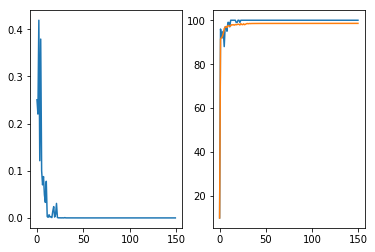

In [7]:
plt.subplot(1, 2, 1)
plt.plot(np.arange(number_of_epochs), running_loss)
plt.subplot(1, 2, 2)
plt.plot(np.arange(number_of_epochs + 1), running_training_accuracy, \
         np.arange(number_of_epochs + 1), running_test_accuracy)

In case we have pre-trained the network and stored its parameters in 'trained_ode_net' we can load the network with the following command.

In [ ]:
ode_net.load_state_dict(torch.load('trained_ode_net'))

In the next plot we visualise the learned values of the step-size parameter $\alpha \in \mathbb{R}^{\text{number_of_layers}}$.

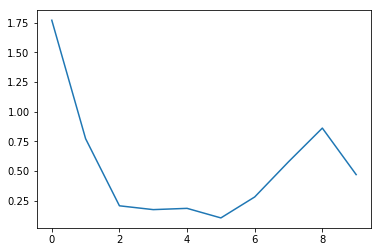

In [8]:
ode_net.eval()
parameter_list = list(ode_net.parameters())
plt.plot(np.arange(number_of_layers), parameter_list[0].detach().numpy())
plt.xlabel('No. of layers')
plt.ylabel($\alpha^{[j]}$)

Last but not least, we load images and labels from the MNIST test dataset, store them in *test_images* and *test_labels* and apply the forward-pass of the ODEnet (via *ode_net.ode_forward*) to *test_images* and store the output in *intermediate_outputs*.

In [9]:
test_images, test_labels = iter(test_loader).next()
intermediate_outputs = ode_net.ode_forward(test_images.view(-1, number_of_pixels)).view(-1, 28, 28)

We visualise one particular test input and the corresponding intermediate output together with the subsequent application of $ W $ and the softmax function *torch.nn.functional.softmax* onto the intermediate output that shows the class prediction for the input images.

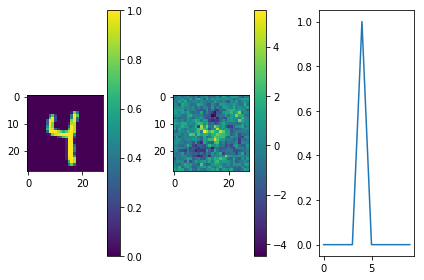

In [10]:
plt.subplot(1, 3, 1)
plt.imshow(test_images[2][0].numpy())
plt.colorbar()
plt.subplot(1, 3, 2)
plt.imshow(intermediate_outputs[2].detach().numpy())
plt.colorbar()
plt.subplot(1, 3, 3)
plt.plot(torch.nn.functional.softmax(torch.mv(parameter_list[len(parameter_list) - 1], \
                            intermediate_outputs[2].view(-1)), dim=0).detach().numpy())
plt.tight_layout()